## Imports
* Numpy is the barebones of this network. 
* h4py is used to read the Coursera dataset.
* matplotlib is for the figures in the notebook
  We also make it inline so that it can render the charts here in the notebook itself. 

In [106]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

## Kaggle Dataset
The kaggle dataset with its description is listed [here](https://www.kaggle.com/c/dogs-vs-cats). The dataset provides images in a lot of varying sizes. We preprocessed the data and converted all the images to a standard size of (64, 64, 3) and then saved the data into two files `train.npz` and `valid.npz`. We use those to load the data.

In [90]:
def load_kaggle_dataset():
    train = np.load('train.npz')
    valid = np.load('valid.npz')
    train_x_original, train_y = train['X'], train['Y']
    valid_x_original, valid_y = valid['X'], valid['Y']
    return train_x_original, train_y, valid_x_original, valid_y
    

## Coursera Dataset
This dataset was made available as a part of the [Deep Learning Specialization](coursera.org/specializations/deep-learning) by Prof. Andrew NG. This dataset is very small comparatively and the data loading script has been taken from the course resources itself. 

In [91]:
def load_coursera_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_x_original = np.array(train_dataset["train_set_x"][:], dtype='float') # your train set features
    train_y = np.array(train_dataset["train_set_y"][:], dtype='float') # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    valid_x_original = np.array(test_dataset["test_set_x"][:], dtype='float') # your test set features
    valid_y = np.array(test_dataset["test_set_y"][:], dtype='float') # your test set labels

    train_y = train_y.reshape((1, train_y.shape[0]))
    valid_y = valid_y.reshape((1, valid_y.shape[0]))
    
    return train_x_original, train_y, valid_x_original, valid_y

Load whichever dataset you want to play with

In [92]:
train_x_original, train_y, valid_x_original, valid_y = load_kaggle_dataset()

Printing out the shapes of all the arrays. **Note:** if you load your own dataset, make sure to bring all of the images in this format. The dimensionality of an image can change obviously and the number of training and test samples can vary, but the ordering should be the following

`X = (sample_size, img_x, img_y, 3)`
`Y = (1, sample_size)`

In [93]:
train_x_original.shape, valid_x_original.shape, train_y.shape, valid_y.shape

((20000, 64, 64, 3), (5000, 64, 64, 3), (1, 20000), (1, 5000))

## Image2Vec
Flatten the vectors as explained in the cell before and also we need to normalize our dataset so that the values don't become too large for `sigmoid`. Sigmoid tends to return 0 for very large or very small values and hence we want to avoid that here. We are using the sigmoid function because this is a binary classification problem.


In [95]:
def image2vec(image_rgb_matrix):
    return image_rgb_matrix.reshape(image_rgb_matrix.shape[0], -1).T
        

In [96]:
train_x = image2vec(train_x_original)
valid_x = image2vec(valid_x_original)
        
print ("sanity check after reshaping: " + str(train_x[0:5,0]))

""" Normalize our dataset """
train_x /= 255.
valid_x /= 255.

train_x.shape, valid_x.shape

sanity check after reshaping: [19. 30. 48. 31. 45.]


((12288, 20000), (12288, 5000))

## Sigmoid Function
Below the function is the graph showing the plot for the same. As we can see from the figure, for very low or very high values, sigmoid returns a 0 value. Hence, we need to normalize our images' data. Also, for the weight and bias initializations, we need to make sure they are small enough for the learning to proceed at a decent pace. Too large weight values can wreak havoc.

In [97]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

## Mean Squared Loss Function
Here we use the mean squared loss function. The averaging part is done inside the caller function.
$$\frac {1}{2m} \sum_{i=1}^m (\hat{Y} - Y)^2$$

In [114]:
def mean_squared_loss(A, Y):
    return (A - Y)**2

## Forward Propagation

* Apply linear transformation.
* Apply sigmoid activation.

$$\sigma(W^T.X + b)$$

In [99]:
def forward_propagate(X, W, b):
    
    """ Number of training samples """
    m = X.shape[1]
    
    """ We do the linear transformation of our entire dataset. (W.X + b) """
    linear_transformation = np.matmul(W.T, X) + b
    
    """ Apply sigmoid activation to bring outputs within range [0..1] """
    activation = sigmoid(linear_transformation)
    
    return activation
    

## Backpropagation

* We follow the steps from the very end of the computational graph back to the initial weights and the bias.
* dY_hat is the partial derivative of the error function J with respect to $\hat{Y}$
1. $ \; \frac {\partial J}{\partial \hat{Y}} = \hat{Y} - Y\\ $

2. $ \; \frac {\partial J}{\partial \hat{A}} = \frac {\partial J}{\partial \hat{Y}} \times \sigma(A) \times (1 - \sigma(A))\\ $

3. $\; \frac {\partial J}{\partial \hat{W}} = \; \frac {\partial J}{\partial \hat{A}} X\\ $

4. $\; \frac {\partial J}{\partial \hat{b}} = \; \frac {\partial J}{\partial \hat{A}}\\ $

In [116]:
def backpropagate(A, X, Y):
    # Y is of shape 1-by-m
    m = Y.shape[1]
    
    dY_hat = A - Y
    dA = dY_hat * sigmoid(A) * (1 - sigmoid(A))
    
    """ Average the value for dW and dB to get the mean learning signal """
    dW = (1/float(m)) * np.matmul(X, dA.T)
    db = (1/float(m)) * np.sum(dA)
    return dW, db

## Forward and Back-propagation combined
Note the use of `is_eval` variable here. We use it so that we can call the same `propagate` function even during test time. During test time we don't really need to do backpropagation. We just need forward propagation and loss calculation then.

In [121]:
def propagate(X, Y, W, b, is_eval=False):
    
    # Number of samples in the dataset.
    m = X.shape[1]
    
    # Forward propagation
    A = forward_propagate(X, W, b)
    
    """ Average loss over the entire dataset """
    loss = (1 / float(2*m)) * np.sum(mean_squared_loss(A, Y))
    
    if not is_eval:
        # Backpropagation
        dW, db = backpropagate(A, X, Y)
        return loss, dW, db
    return loss
        

## Bringing it all together under the model function

* Iterate over the epochs
    * Do forward and back-propagation on the training set.
    * Perform gradient descent i.e. adjust the weights and the bias.
    * Run the model on the validation dataset to measure the actual performance. 

In [102]:
def model(train_X, train_Y, valid_X, valid_Y, W, B, epochs, learning_rate, print_interval=100):
    train_loss = []
    valid_loss = []
    
    for itr in range(epochs):
        """ Do one pass of forward and backward propagation on the training dataset."""
        training_loss, dW, dB = propagate(train_X, train_Y, W, B)
        train_loss.append(training_loss)
        
        """ SGD on the parameters """
        W = W - (learning_rate * dW)
        B = B - (learning_rate * dB)
        
        """ Evaluate on the validation dataset and record the loss"""
        validation_loss = propagate(valid_X, valid_Y, W, B, is_eval=True)
        valid_loss.append(validation_loss)
        
        """ Print after every `print_interval` intervals """
        if itr > 0 and itr % print_interval == 0:
            print("Epochs =", itr, "train loss =", training_loss, "and validation loss = ", validation_loss)
    
    params = {"w": W,
              "b": B}
    
    return train_loss, valid_loss, params

## Model's parameter initialization
We can use random initialization here as well but this works equally well for our use-case.

In [112]:
def init(dim):
    W = np.zeros((dim, 1))
    B = 0.
    return W, B

## Predict function
We can call this function to make actual predictions on our validation dataset and this function returns the percentage of images correctly classified. 

In [104]:
def predict(W, b, X, Y):
    """ Number of examples in the test set"""
    m = Y.shape[1]
    
    """ Forward propagation on the images in the test set """
    A = sigmoid(np.dot(W.T, X) + b)
    
    """ 
        Use the activation values to make a prediction by the model.
        If the activation is > 0.5, that means our model predicts class 1
        else class 0. That's just the way we have set up. We can 
        set it up any which way and train the model accordingly.
    """
    Y_prediction = A > 0.5
    
    """ Finally finding out how many predictions we got right """
    return np.sum(Y_prediction == Y) * 100 / m

In [122]:
W, B = init(train_x.shape[0])
training_losses, validation_losses, params = model(train_x, train_y, valid_x, valid_y, W, B, 5000, 0.003, print_interval=500)

W = params["w"]
B = params["b"]

# Print train/test Errors
print("Train accuracy: {} %".format(predict(W, B, train_x, train_y)))
print("Test accuracy: {} %".format(predict(W, B, valid_x, valid_y)))

Epochs = 500 train loss = 0.12019886887431529 and validation loss =  0.11963075319798072
Epochs = 1000 train loss = 0.1188053758866622 and validation loss =  0.11822058730184222
Epochs = 1500 train loss = 0.11800288932091886 and validation loss =  0.11746387806416676
Epochs = 2000 train loss = 0.11743974342547964 and validation loss =  0.11697881414906237
Epochs = 2500 train loss = 0.11699756098960666 and validation loss =  0.1166346189429638
Epochs = 3000 train loss = 0.11662539583622211 and validation loss =  0.1163726064516623
Epochs = 3500 train loss = 0.11629820054716138 and validation loss =  0.11616242365105446
Epochs = 4000 train loss = 0.11600248098271147 and validation loss =  0.1159869674773287
Epochs = 4500 train loss = 0.11573042225953893 and validation loss =  0.11583602541054357
Train accuracy: 61.48 %
Test accuracy: 61.62 %


## Plotting the losses over epochs.
**Note:** the validation loss is decreasing over all the 5000 epochs showing no signs of overfitting whatsoever. Also, the validation loss mimics the training loss here which is a sign of a properly trained model.

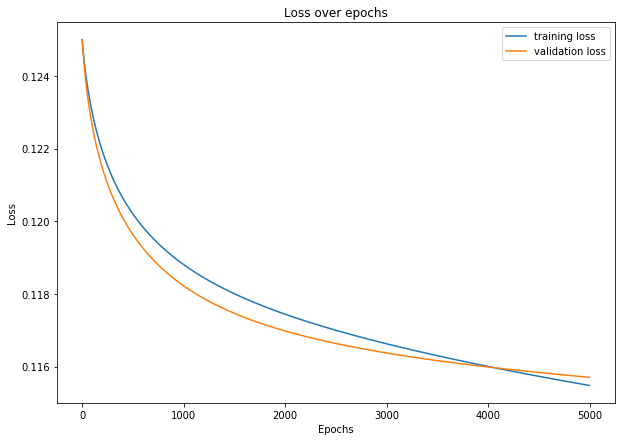

In [123]:
X = np.arange(0, 5000)
trainY = training_losses
validY = validation_losses
plt.figure(figsize=(10,7))
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(X, trainY, label="training loss")
plt.plot(X, validY, label="validation loss")
plt.legend(loc="best")

## Prediction on a custom image.

It's a cat


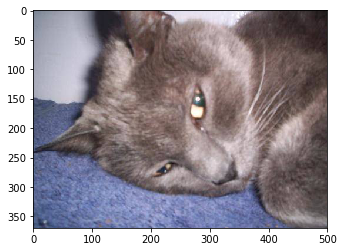

In [155]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg
from skimage.transform import resize
path_to_image = "cat.jpg"
custom_image = np.asarray(mpimg.imread(path_to_image))
custom_image_resized = resize(custom_image, (64, 64, 3))
custom_image_resized = np.expand_dims(custom_image_resized, axis=0)
custom_image_resized = image2vec(custom_image_resized) / 255.
activation = forward_propagate(custom_image_resized, W, B)
plt.imshow(custom_image)
print("It's a cat" if activation > 0.5 else "It's a dog")